In [1]:
import pandas as pd
import numpy as np
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
data = pd.read_csv('C:\\Users\\91900\\OneDrive\\Documents\\Major project\\Dataset\\final.csv') 
print(data)

              Startdate           Enddate    NH3     CO   Temp     RH
0      01-01-2012 12:00  01-01-2012 13:00   5.22  16.06  31.58  80.90
1      01-01-2012 13:00  01-01-2012 14:00   5.30  18.35  31.74  79.56
2      01-01-2012 14:00  01-01-2012 15:00   5.11  18.71  31.99  81.53
3      01-01-2012 15:00  01-01-2012 16:00   5.12  18.78  32.33  80.33
4      01-01-2012 16:00  01-01-2012 17:00    NaN    NaN    NaN    NaN
...                 ...               ...    ...    ...    ...    ...
98575  31-03-2023 19:00  31-03-2023 20:00  50.93   1.46    NaN  96.79
98576  31-03-2023 20:00  31-03-2023 21:00  49.48   0.46    NaN  98.50
98577  31-03-2023 21:00  31-03-2023 22:00  49.51   0.64    NaN  98.51
98578  31-03-2023 22:00  31-03-2023 23:00  40.77   0.64    NaN  98.53
98579  31-03-2023 23:00  01-04-2023 00:00  42.16   0.50    NaN  98.55

[98580 rows x 6 columns]


In [3]:
data.head()

,Startdate,Enddate,NH3,CO,Temp,RH
0,01-01-2012 12:00,01-01-2012 13:00,5.22,16.06,31.58,80.90
1,01-01-2012 13:00,01-01-2012 14:00,5.30,18.35,31.74,79.56
2,01-01-2012 14:00,01-01-2012 15:00,5.11,18.71,31.99,81.53
3,01-01-2012 15:00,01-01-2012 16:00,5.12,18.78,32.33,80.33
4,01-01-2012 16:00,01-01-2012 17:00,NaN,NaN,NaN,NaN


In [4]:
data['NH3'] = data['NH3'].ffill()
data['NH3'] = data['NH3'].bfill()


data['CO'] = data['CO'].ffill()
data['CO'] = data['CO'].bfill()

data['Temp'] = data['Temp'].ffill()
data['Temp'] = data['Temp'].bfill()

data['RH'] = data['RH'].ffill()
data['RH'] = data['RH'].bfill()

In [5]:
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x > 1 and x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x > 2 and x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x > 10 and x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x > 17 and x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

data["ci"] = data["CO"].astype(float).apply(lambda x: get_CO_subindex(x))

def get_NH3_subindex(x):
    if x <= 200:
        return x * 50 / 200
    elif x > 200 and x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x > 400 and x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x > 800 and x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x > 1200 and x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return 0

data["ni"] = data["NH3"].astype(float).apply(lambda x: get_NH3_subindex(x))

In [6]:
def calculate_aqi(ni,ci):
    aqi=0
  
    if(ni>ci):
     aqi=ni
    if(ci>ni):
      aqi=ci
  
    return aqi
data['AQI']=data.apply(lambda x:calculate_aqi(x['ni'],x['ci']),axis=1)
data.head()

,Startdate,Enddate,NH3,CO,Temp,RH,ci,ni,AQI
0,01-01-2012 12:00,01-01-2012 13:00,5.22,16.06,31.58,80.90,286.571429,1.3050,286.571429
1,01-01-2012 13:00,01-01-2012 14:00,5.30,18.35,31.74,79.56,307.941176,1.3250,307.941176
2,01-01-2012 14:00,01-01-2012 15:00,5.11,18.71,31.99,81.53,310.058824,1.2775,310.058824
3,01-01-2012 15:00,01-01-2012 16:00,5.12,18.78,32.33,80.33,310.470588,1.2800,310.470588
4,01-01-2012 16:00,01-01-2012 17:00,5.12,18.78,32.33,80.33,310.470588,1.2800,310.470588


In [7]:
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x > 50 and x <= 100:
        return "Satisfactory"
    elif x > 100 and x <= 200:
        return "Moderate"
    elif x > 200 and x <= 300:
        return "Poor"
    elif x > 300 and x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return '0'

data['AQI_Bucket'] = data['AQI'].apply(get_AQI_bucket)

In [8]:
final_data= data[['AQI','AQI_Bucket']].copy()
final_data

,AQI,AQI_Bucket
0,286.571429,Poor
1,307.941176,Very Poor
2,310.058824,Very Poor
3,310.470588,Very Poor
4,310.470588,Very Poor
...,...,...
98575,73.000000,Satisfactory
98576,23.000000,Good
98577,32.000000,Good
98578,32.000000,Good


In [21]:
from sklearn.model_selection import TimeSeriesSplit

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor
from bayes_opt import BayesianOptimization


scaler = RobustScaler()
final_data['Scaled_AQI'] = scaler.fit_transform(final_data[['AQI']])

sequence_length = 10

def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:(i + sequence_length)].values)
        y.append(data.iloc[i + sequence_length].values)
    return np.array(X), np.array(y)

X, y = create_sequences(final_data[['Scaled_AQI']], sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
print(X)

[[[ 5.1038961 ]
  [ 5.58957219]
  [ 5.63770053]
  ...
  [ 5.51203209]
  [ 5.22402597]
  [ 5.01298701]]

 [[ 5.58957219]
  [ 5.63770053]
  [ 5.64705882]
  ...
  [ 5.22402597]
  [ 5.01298701]
  [ 4.93831169]]

 [[ 5.63770053]
  [ 5.64705882]
  [ 5.64705882]
  ...
  [ 5.01298701]
  [ 4.93831169]
  [ 5.55347594]]

 ...

 [[ 0.44318182]
  [ 0.17045455]
  [ 0.35227273]
  ...
  [ 0.26136364]
  [ 0.25      ]
  [-0.88636364]]

 [[ 0.17045455]
  [ 0.35227273]
  [ 0.31818182]
  ...
  [ 0.25      ]
  [-0.88636364]
  [-0.68181818]]

 [[ 0.35227273]
  [ 0.31818182]
  [ 0.42045455]
  ...
  [-0.88636364]
  [-0.68181818]
  [-0.68181818]]]


In [24]:
print(y)

[[ 4.93831169]
 [ 5.55347594]
 [ 5.54278075]
 ...
 [-0.68181818]
 [-0.68181818]
 [-0.84090909]]


In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasRegressor
from bayes_opt import BayesianOptimization



def create_model(units, dropout_rate, l2_rate):
    model = Sequential([
        LSTM(units=int(units), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), 
             kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        LSTM(units=int(units), return_sequences=False, kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        Dense(units=int(units/2), activation='relu', kernel_regularizer=l2(l2_rate)),  
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def lstm_model_optimization(units, dropout_rate, l2_rate):
    model = create_model(units=units, dropout_rate=dropout_rate, l2_rate=l2_rate)
    model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    return -loss  


pbounds = {
    'units': (20, 100),
    'dropout_rate': (0.1, 0.5),
    'l2_rate': (0.0001, 0.01)  
}

optimizer = BayesianOptimization(
    f=lstm_model_optimization,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(init_points=2, n_iter=10)

best_params = optimizer.max['params']
print("Best parameters:", best_params)


best_model = create_model(
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    l2_rate=best_params['l2_rate']
)


best_model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)


test_loss = best_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)



|   iter    |  target   | dropou... |  l2_rate  |   units   |
-------------------------------------------------------------


c:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 1         | -0.3587   | 0.2668    | 0.007231  | 20.01     |
| 2         | -0.3551   | 0.2209    | 0.001553  | 27.39     |


c:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 3         | -0.3525   | 0.2501    | 0.005988  | 27.58     |


c:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 4         | -0.3533   | 0.2482    | 0.007695  | 27.77     |


c:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 5         | -0.3573   | 0.4644    | 0.007728  | 27.6      |


c:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 6         | -0.3599   | 0.191     | 0.00164   | 95.78     |


c:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 7         | -0.3604   | 0.3905    | 0.007313  | 35.58     |


c:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 8         | -0.3538   | 0.1247    | 0.002709  | 27.68     |


c:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 9         | -0.3627   | 0.4822    | 0.006674  | 57.66     |


c:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 10        | -0.3888   | 0.2955    | 0.008428  | 98.33     |


c:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 11        | -0.371    | 0.3178    | 0.01      | 29.1      |


c:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


| 12        | -0.352    | 0.4471    | 0.001636  | 21.19     |
Best parameters: {'dropout_rate': 0.44708717317521607, 'l2_rate': 0.0016362510378895578, 'units': 21.18736046329972}
Epoch 1/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.6452
Epoch 2/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.4245
Epoch 3/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.4076
Epoch 4/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.4060
Epoch 5/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.4075
Epoch 6/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.3761
Epoch 7/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.3799
Epoch 8/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.3747
Epoch 9/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.3833
Epoch 10/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.3914
Epoch 11/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.3778
Epoch 12/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 10s 8m

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error
import numpy as np


best_model = create_model(
    units=best_params['units'], 
    dropout_rate=best_params['dropout_rate'], 
    l2_rate=best_params['l2_rate']  
)

best_model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)


test_loss = best_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)


predictions = best_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:', mae)


future_steps = 10
last_sequence = X_test[-1]
forecasted_aqi_values = []

for _ in range(future_steps):
    last_sequence = last_sequence.reshape((1, sequence_length, 1))
    next_aqi_value = best_model.predict(last_sequence)
    forecasted_aqi_values.append(next_aqi_value[0][0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1] = next_aqi_value[0][0]

forecasted_aqi_values = scaler.inverse_transform(np.array(forecasted_aqi_values).reshape(-1, 1))

print("Forecasted AQI Values for the Next", future_steps, "Time Steps:")
for i, aqi_value in enumerate(forecasted_aqi_values):
    print(f"AQI {i+1}: {aqi_value}")


Epoch 1/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.6430
Epoch 2/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.4295
Epoch 3/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.4097
Epoch 4/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.3964
Epoch 5/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.4095
Epoch 6/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.3941
Epoch 7/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.3891
Epoch 8/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.3845
Epoch 9/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.3944
Epoch 10/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.3789
Epoch 11/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.4014
Epoch 12/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.4035
Epoch 13/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.3917
Epoch 14/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.3664
Epoch 15/50
123

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


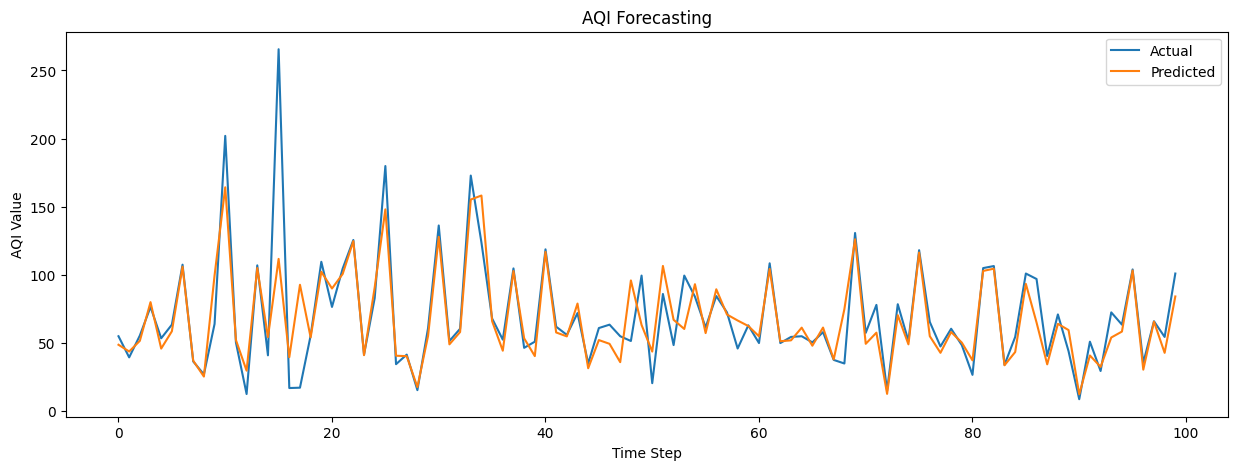

In [27]:
import matplotlib.pyplot as plt


predicted_aqi_values_scaled = best_model.predict(X_test)


predicted_aqi_values = scaler.inverse_transform(predicted_aqi_values_scaled)


actual_aqi_values = scaler.inverse_transform(y_test)


N = 100  
plt.figure(figsize=(15, 5))


plt.plot(actual_aqi_values[:N], label='Actual')


plt.plot(predicted_aqi_values[:N], label='Predicted')

plt.title('AQI Forecasting')
plt.xlabel('Time Step')

plt.ylabel('AQI Value')
plt.legend()
plt.show()

In [10]:
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
from sklearn.preprocessing import RobustScaler


cred_path = "C:\\Users\\91900\\OneDrive\\Documents\\Major project\\Firebase\\iot-and-esp-32-firebase-adminsdk-j6hfv-0c533f4313.json"
database_url = 'https://iot-and-esp-32-default-rtdb.asia-southeast1.firebasedatabase.app/'

cred = credentials.Certificate(cred_path)

firebase_admin.initialize_app(cred, {
    'databaseURL': database_url
})


ref = db.reference('pollutant_values')
pollutant_values = ref.get()


data = pd.DataFrame.from_dict(pollutant_values, orient='index')


data["ni"] = data["NH3"].apply(get_NH3_subindex)
data["ci"] = data["CO"].apply(get_CO_subindex)



data['AQI'] = data.apply(lambda x: calculate_aqi(x['ni'], x['ci']), axis=1)


scaler = RobustScaler()
data['Scaled_AQI'] = scaler.fit_transform(data[['AQI']])

def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data.iloc[i:(i + sequence_length)].values
        y = data.iloc[i + sequence_length].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


sequence_length = 10
X, y = create_sequences(data[['Scaled_AQI']], sequence_length)
sequence_length = 10
X, _ = create_sequences(data[['Scaled_AQI']], sequence_length)

In [11]:
data.head()

,AQI,AQI Level String,CO,NH3,ni,ci,Scaled_AQI
1624,491.171471,Severe,49.49915,1.16882,0.292205,491.171471,2.002775
1813,9.298000,Good,0.18596,0.00000,0.000000,9.298000,-4.152561
1817,738.488529,Severe,91.54305,1.45446,0.363615,738.488529,5.161944
4751,116.512250,NaN,3.32098,1.43518,0.358795,116.512250,-2.783032
11624,439.872471,Severe,40.77832,1.07448,0.268620,439.872471,1.347494


In [12]:
print(X)

[[[ 2.00277529e+00]
  [-4.15256077e+00]
  [ 5.16194404e+00]
  [-2.78303168e+00]
  [ 1.34749417e+00]
  [-9.50766736e-01]
  [ 4.05913875e+00]
  [ 4.06856145e+13]
  [ 1.07521321e+00]
  [-7.30734211e-03]]

 [[-4.15256077e+00]
  [ 5.16194404e+00]
  [-2.78303168e+00]
  [ 1.34749417e+00]
  [-9.50766736e-01]
  [ 4.05913875e+00]
  [ 4.06856145e+13]
  [ 1.07521321e+00]
  [-7.30734211e-03]
  [ 3.73286762e+00]]

 [[ 5.16194404e+00]
  [-2.78303168e+00]
  [ 1.34749417e+00]
  [-9.50766736e-01]
  [ 4.05913875e+00]
  [ 4.06856145e+13]
  [ 1.07521321e+00]
  [-7.30734211e-03]
  [ 3.73286762e+00]
  [ 4.06856145e+13]]

 [[-2.78303168e+00]
  [ 1.34749417e+00]
  [-9.50766736e-01]
  [ 4.05913875e+00]
  [ 4.06856145e+13]
  [ 1.07521321e+00]
  [-7.30734211e-03]
  [ 3.73286762e+00]
  [ 4.06856145e+13]
  [ 7.68395013e-01]]

 [[ 1.34749417e+00]
  [-9.50766736e-01]
  [ 4.05913875e+00]
  [ 4.06856145e+13]
  [ 1.07521321e+00]
  [-7.30734211e-03]
  [ 3.73286762e+00]
  [ 4.06856145e+13]
  [ 7.68395013e-01]
  [-7.877126

In [13]:
print(y)

[[ 3.73286762e+00]
 [ 4.06856145e+13]
 [ 7.68395013e-01]
 [-7.87712695e-02]
 [ 3.08278317e+00]
 [ 4.06856145e+13]
 [ 6.95831791e-01]
 [-2.29557992e-01]
 [ 2.76333548e+00]
 [ 2.06759212e+02]
 [ 7.76582993e-01]
 [-2.50098198e-01]
 [ 2.59791003e+00]
 [ 6.79978052e-01]
 [ 2.10098371e+00]
 [ 6.02155046e-01]
 [ 1.89534120e+00]
 [ 6.40767868e-01]
 [ 1.76826108e+00]
 [ 5.19258603e-01]
 [ 4.14147841e-01]
 [ 4.35516087e-01]
 [ 3.68510953e-01]
 [ 2.76548147e-01]
 [ 2.69884753e-01]
 [ 1.94671351e-01]
 [ 1.37593683e-01]
 [ 1.37593683e-01]
 [ 1.15810665e-01]
 [ 3.68643199e-02]
 [ 7.30734211e-03]
 [-1.89209441e-02]
 [-8.99618346e-02]
 [-1.03855929e-01]
 [-1.01085525e-01]
 [-1.50335133e-01]
 [-1.55726411e-01]
 [-1.66461629e-01]
 [-2.29557992e-01]
 [-1.77134481e-01]
 [-2.29557992e-01]
 [-2.52648442e-01]
 [-2.50098198e-01]
 [-2.65344808e-01]
 [-2.95436781e-01]
 [-2.39858151e-01]
 [-1.17648584e-01]
 [-1.06622575e-01]
 [-9.55319454e-02]
 [-1.23136792e-01]
 [-2.29557992e-01]
 [-2.29557992e-01]
 [-2.2955799

In [32]:
import joblib
from tensorflow.keras.models import load_model


model_path = "C:\\Users\\91900\\OneDrive\\Documents\\Major project\\Models\\aqi_forecasting_model.keras"
scaler_path = "C:\\Users\\91900\\OneDrive\\Documents\\Major project\\Models\\aqi_scaler.save"


best_model.save(model_path)  


joblib.dump(scaler, scaler_path)


['C:\\Users\\91900\\OneDrive\\Documents\\Major project\\Models\\aqi_scaler.save']

In [14]:
import joblib
from tensorflow.keras.models import load_model


model_path = "C:\\Users\\91900\\OneDrive\\Documents\\Major project\\Models\\aqi_forecasting_model.keras"
scaler_path = "C:\\Users\\91900\\OneDrive\\Documents\\Major project\\Models\\aqi_scaler.save"


loaded_model = load_model(model_path)


loaded_scaler = joblib.load(scaler_path)


In [15]:
predicted_aqi_scaled = loaded_model.predict(X)
predicted_aqi = loaded_scaler.inverse_transform(predicted_aqi_scaled)

recent_predictions = predicted_aqi[-10:]
print("Most Recent 10 Predicted AQI Values:")
for value in recent_predictions:
    print(value)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 810ms/step
Most Recent 10 Predicted AQI Values:
[318.18903]
[319.8225]
[318.76578]
[314.0799]
[313.13025]
[312.54565]
[312.21872]
[311.65118]
[311.31046]
[309.42575]


Epoch 1/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.3811 - val_loss: 0.3391
Epoch 2/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.3689 - val_loss: 0.3378
Epoch 3/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.3610 - val_loss: 0.3451
Epoch 4/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.3804 - val_loss: 0.3358
Epoch 5/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.3543 - val_loss: 0.3449
Epoch 6/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.3724 - val_loss: 0.3378
Epoch 7/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.3999 - val_loss: 0.3335
Epoch 8/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.3844 - val_loss: 0.3442
Epoch 9/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.3643 - val_loss: 0.3359
Epoch 10/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.3608 - val_loss: 0.3386
Epoch 11/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.3734 - val_loss: 0.3478
Epoch 12/50
986/986 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/s

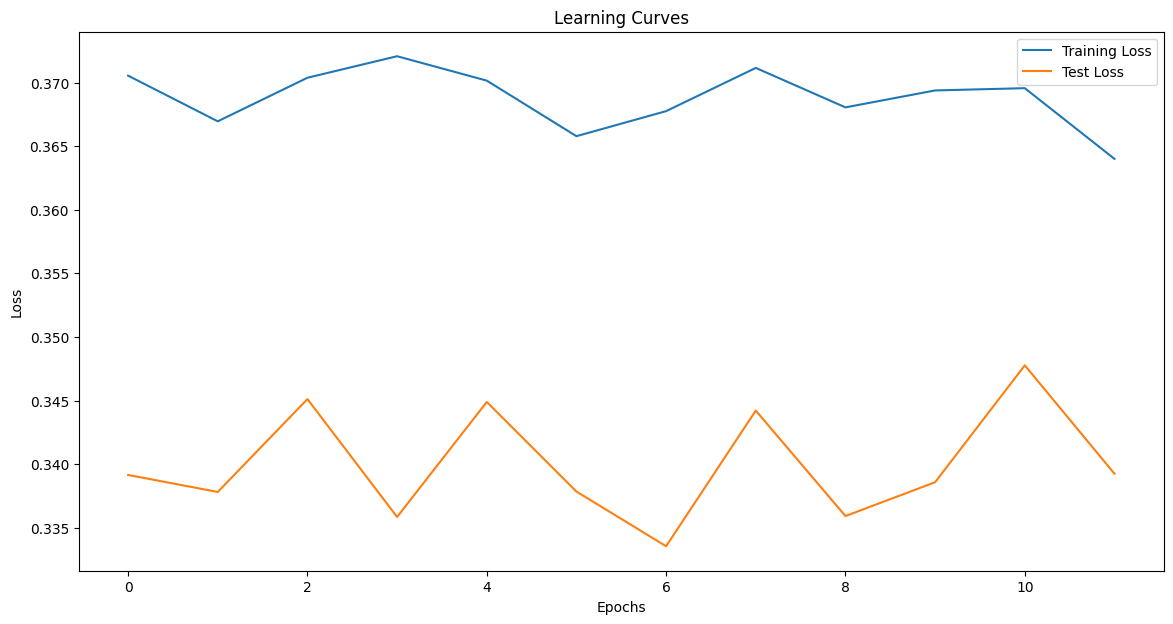

Lowest Validation Loss: 0.33354583382606506
Training Loss: 0.33806973695755005
Test Loss: 0.3533012866973877


In [35]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)


history = best_model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=64, 
    verbose=1, 
    validation_split=0.2,  
    callbacks=[early_stopping, model_checkpoint]
)


plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

if 'val_loss' in history.history:
    print(f"Lowest Validation Loss: {min(history.history['val_loss'])}")


train_loss = best_model.evaluate(X_train, y_train, verbose=0)
test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')




In [36]:
import streamlit as st
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Function to calculate AQI
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x > 1 and x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x > 2 and x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x > 10 and x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x > 17 and x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

def get_NH3_subindex(x):
    if x <= 200:
        return x * 50 / 200
    elif x > 200 and x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x > 400 and x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x > 800 and x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x > 1200 and x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return 0

def calculate_aqi(ni, ci):
    aqi = 0
    if ni > ci:
        aqi = ni
    if ci > ni:
        aqi = ci
    return aqi

model_path = "C:\\Users\\91900\\OneDrive\\Documents\\Major project\\Models\\aqi_forecasting_model"
scaler_path = "C:\\Users\\91900\\OneDrive\\Documents\\Major project\\Models\\aqi_scaler.save"

loaded_model = load_model(model_path)


loaded_scaler = RobustScaler()


st.title('AQI Forecasting App')

st.write('Enter NH3 and CO values:')


nh3 = st.number_input('NH3', value=0.0, step=0.01)
co = st.number_input('CO', value=0.0, step=0.01)


if st.button('Predict AQI'):
    # Calculate subindices for NH3 and CO
    ni = get_NH3_subindex(nh3)
    ci = get_CO_subindex(co)
    # Calculate AQI
    aqi = calculate_aqi(ni, ci)
    # Scale the AQI
    scaled_aqi = loaded_scaler.transform([[aqi]])
    # Reshape for model input
    scaled_input = scaled_aqi.reshape(1, 1, 1)
    # Make prediction using the loaded model
    predicted_aqi = loaded_model.predict(scaled_input)
    # Inverse transform the predicted scaled AQI value
    predicted_aqi = loaded_scaler.inverse_transform(predicted_aqi)
    # Display the predicted AQI
    st.write('Predicted AQI:', predicted_aqi[0][0])


ModuleNotFoundError: No module named 'streamlit'